## Bike sharing dataset

Taken from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

### Data Set Information

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

### Attribute Information

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered


In [1]:
import altair as alt
import numpy as np
import pandas as pd
import panel as pn
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting import plot_series

# https://altair-viz.github.io/user_guide/faq.html#local-filesystem
alt.data_transformers.enable("json")

# https://towardsdatascience.com/how-to-build-a-time-series-dashboard-in-python-with-panel-altair-and-a-jupyter-notebook-c0ed40f02289
alt.renderers.enable("default")
pn.extension("vega")

In [2]:
def parse_date_hour(date, hour):
    """Construct datetime for index of hourly data."""
    return pd.to_datetime(" ".join([date, str(hour).zfill(2)]), format="%Y-%m-%d %H")


daily = pd.read_csv("bike-sharing-daily-processed.csv", parse_dates=["dteday"]).drop(
    columns=["instant", "Unnamed: 0"]
)
hourly = pd.read_csv("hour.csv").drop(columns=["instant"])
hourly.index = pd.DatetimeIndex(
    hourly.apply(lambda row: parse_date_hour(row.dteday, row.hr), axis=1),
    name="timestamp",
)

In [3]:
daily.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,days_since_2011
0,2011-01-01,SPRING,2011,1,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,28.363250,80.5833,10.749882,331,654,985,0
1,2011-01-02,SPRING,2011,1,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,28.027126,69.6087,16.652113,131,670,801,1
2,2011-01-03,SPRING,2011,1,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,22.439770,43.7273,16.636703,120,1229,1349,2
3,2011-01-04,SPRING,2011,1,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,23.212148,59.0435,10.739832,108,1454,1562,3
4,2011-01-05,SPRING,2011,1,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,23.795180,43.6957,12.522300,82,1518,1600,4


## EDA with an interactive dashboard

In [4]:
title = "## Daily bikesharing count"
subtitle = "Total count = casual + registered users"

# interactive date reange
date_range_slider = pn.widgets.DateRangeSlider(
    name="date",
    start=pd.to_datetime("2011-01-01"),
    end=pd.to_datetime("2012-12-31"),
    value=(pd.to_datetime("2011-01-01"), pd.to_datetime("2012-01-01")),
)


@pn.depends(date_range_slider.param.value)
def get_plot(date_range, df=daily, x="dteday", y="cnt"):
    """Dashboard for exploring timeseries.

    Args
    ----
        x: date or timestamp
        y: univariate timeseries

    """
    start_date = date_range_slider.value[0]
    end_date = date_range_slider.value[1]
    mask = (df[x] > start_date) & (df[x] <= end_date)
    df = df.loc[mask]
    chart = alt.Chart(df).mark_line().encode(x=x, y=y).properties(width=800)
    return chart


dash = pn.Column(title, subtitle, get_plot, date_range_slider, width=800)
dash.servable()

Column(width=800)
    [0] Markdown(str)
    [1] Markdown(str)
    [2] ParamFunction(function)
    [3] DateRangeSlider(end=Timestamp('2012-12-31 0..., name='date', start=Timestamp('2011-01-01 0..., value=(Timestamp('2011-01-01 00:..., value_throttled=(Timestamp('2011-01-01 00:...)

In [5]:
monthly = daily.groupby(['yr', 'mnth'], as_index=False)['cnt'].sum('cnt')
monthly['yr_mnth'] = monthly.apply(lambda df: '-'.join([str(df.yr), str(df.mnth).zfill(2)]), axis=1)

def simple_ts_plot(df, x='yr_mnth', y='cnt', width=800, height=200):
    return alt.Chart(df).mark_line().encode(x=x, y=y).properties(width=800)

simple_ts_plot(monthly)

alt.Chart(...)

## Decomposition with statsmodels

### Simple decomposition

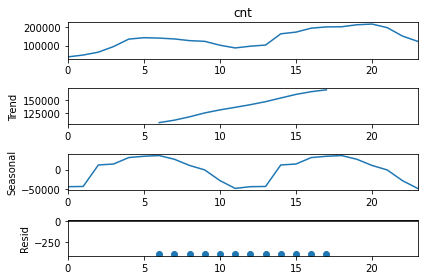

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

simple_decomposition = seasonal_decompose(monthly.cnt, period=12)
simple_decomposition.plot();

### STL decomposition

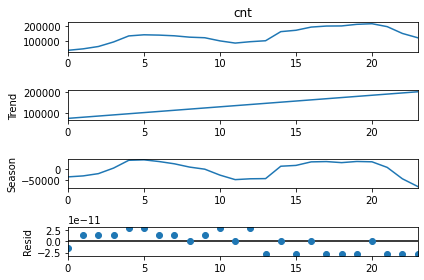

In [13]:
stl = STL(monthly.cnt, period=12).fit()
stl.plot();

In [14]:
_ts = {}
for result in ['observed', 'trend', 'seasonal', 'resid']:
    df = pd.DataFrame({'yr_mnth': monthly.yr_mnth, result: getattr(stl, result)})
    _ts[result] = simple_ts_plot(df, x='yr_mnth', y=result, height=50)


alt.vconcat(*_ts.values()).resolve_scale(x='shared')

alt.VConcatChart(...)

In [21]:
y_train, y_test = temporal_train_test_split(monthly.cnt, test_size=12)